In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
data_df = pd.read_csv('simulation_sigmoidal.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
data_df

,sbj,trial,value_0,value_1,gaze_0,gaze_1,true_drift_0,true_drift_1,true_threshold,true_ndt,rt,choice
0,1,1,1.515307,5.702139,0.815368,0.184632,0.121320,1.248028,2.685671,0.795103,3.872103,1.0
1,1,2,5.800809,2.890693,0.057070,0.942930,0.368604,1.114728,2.685671,0.795103,4.199103,1.0
2,1,3,1.944349,5.512755,0.843520,0.156480,0.294848,0.969239,2.685671,0.795103,6.267103,0.0
3,1,4,3.209306,2.883418,0.287988,0.712012,0.287546,0.935792,2.685671,0.795103,2.464103,1.0
4,1,5,2.712884,5.816233,0.648374,0.351626,0.198987,1.571247,2.685671,0.795103,2.376103,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19969,100,196,5.225284,3.893592,0.069201,0.930799,0.280720,1.671857,2.387208,0.342712,2.245712,0.0
19970,100,197,1.903090,5.451513,0.860396,0.139604,0.267699,1.122338,2.387208,0.342712,1.828712,0.0
19971,100,198,5.879627,2.626809,0.333723,0.666277,1.663182,0.218219,2.387208,0.342712,1.650712,0.0
19972,100,199,1.102391,3.910916,0.890860,0.109140,0.172870,0.749631,2.387208,0.342712,1.477712,1.0


In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.3)

obs_train = np.asarray(tr_df[['rt', 'choice']], dtype=np.float32)
X_train = np.asarray(tr_df[['value_0', 'value_1', 'gaze_0', 'gaze_1']], dtype=np.float32)

obs_test = np.asarray(ts_df[['rt', 'choice']], dtype=np.float32)
X_test = np.asarray(ts_df[['value_0', 'value_1', 'gaze_0', 'gaze_1']], dtype=np.float32)

print(X_train.shape, X_test.shape)

(13975, 4) (5999, 4)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
#     ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    ndt = tf.convert_to_tensor([min_rt[i]/(1+ tf.math.log(1 + tf.exp(model.layers[-1].weights[-1][i-1]))) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 312       
                                                                 
Total params: 605 (2.36 KB)
Trainable params: 605 (2.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [22]:
history = model.fit(X_train, obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/500
1/1 [==============================] - 0s 291ms/step - loss: nan
Epoch 2/500
1/1 [==============================] - 0s 166ms/step - loss: 27412.2852
Epoch 3/500
1/1 [==============================] - 0s 165ms/step - loss: 27417.1211
Epoch 4/500
1/1 [==============================] - 0s 159ms/step - loss: 27420.9219
Epoch 5/500
1/1 [==============================] - 0s 170ms/step - loss: 27424.1777
Epoch 6/500
1/1 [==============================] - 0s 172ms/step - loss: 27422.5293
Epoch 7/500
1/1 [==============================] - 0s 175ms/step - loss: 27419.7617
Epoch 8/500
1/1 [==============================] - 0s 164ms/step - loss: 27415.2676
Epoch 9/500
1/1 [==============================] - 0s 164ms/step - loss: 27413.9551
Epoch 10/500
1/1 [==============================] - 0s 167ms/step - loss: 27409.9180
Epoch 11/500
1/1 [==============================] - 0s 161ms/step - loss: 27409.4629
Epoch 12/500
1/1 [==============================] - 0s 163ms/step - loss: 27408.9

1/1 [==============================] - 0s 191ms/step - loss: 27403.1895
Epoch 98/500
1/1 [==============================] - 0s 175ms/step - loss: 27403.3262
Epoch 99/500
1/1 [==============================] - 0s 162ms/step - loss: 27404.8984
Epoch 100/500
1/1 [==============================] - 0s 174ms/step - loss: 27404.4570
Epoch 101/500
1/1 [==============================] - 0s 161ms/step - loss: 27408.6973
Epoch 102/500
1/1 [==============================] - 0s 163ms/step - loss: 27417.3418
Epoch 103/500
1/1 [==============================] - 0s 165ms/step - loss: 27433.3359
Epoch 104/500
1/1 [==============================] - 0s 153ms/step - loss: 27432.0117
Epoch 105/500
1/1 [==============================] - 0s 179ms/step - loss: 27422.5918
Epoch 106/500
1/1 [==============================] - 0s 214ms/step - loss: 27410.2793
Epoch 107/500
1/1 [==============================] - 0s 190ms/step - loss: 27404.8945
Epoch 108/500
1/1 [==============================] - 0s 178ms/step - l

1/1 [==============================] - 0s 157ms/step - loss: 27426.6543
Epoch 193/500
1/1 [==============================] - 0s 162ms/step - loss: 27424.8867
Epoch 194/500
1/1 [==============================] - 0s 153ms/step - loss: 27415.7852
Epoch 195/500
1/1 [==============================] - 0s 162ms/step - loss: 27411.3984
Epoch 196/500
1/1 [==============================] - 0s 164ms/step - loss: 27407.4883
Epoch 197/500
1/1 [==============================] - 0s 156ms/step - loss: 27411.2031
Epoch 198/500
1/1 [==============================] - 0s 157ms/step - loss: 27417.3496
Epoch 199/500
1/1 [==============================] - 0s 156ms/step - loss: 27413.8516
Epoch 200/500
1/1 [==============================] - 0s 158ms/step - loss: 27410.6328
Epoch 201/500
1/1 [==============================] - 0s 158ms/step - loss: 27408.4297
Epoch 202/500
1/1 [==============================] - 0s 161ms/step - loss: 27408.3125
Epoch 203/500
1/1 [==============================] - 0s 159ms/step -

1/1 [==============================] - 0s 165ms/step - loss: 27434.2715
Epoch 288/500
1/1 [==============================] - 0s 161ms/step - loss: 27421.6934
Epoch 289/500
1/1 [==============================] - 0s 160ms/step - loss: 27408.9395
Epoch 290/500
1/1 [==============================] - 0s 160ms/step - loss: 27408.5566
Epoch 291/500
1/1 [==============================] - 0s 160ms/step - loss: 27405.3184
Epoch 292/500
1/1 [==============================] - 0s 156ms/step - loss: 27402.2910
Epoch 293/500
1/1 [==============================] - 0s 160ms/step - loss: 27404.6973
Epoch 294/500
1/1 [==============================] - 0s 154ms/step - loss: 27406.6875
Epoch 295/500
1/1 [==============================] - 0s 159ms/step - loss: 27407.2617
Epoch 296/500
1/1 [==============================] - 0s 158ms/step - loss: 27411.5566
Epoch 297/500
1/1 [==============================] - 0s 161ms/step - loss: 27412.3730
Epoch 298/500
1/1 [==============================] - 0s 159ms/step -

1/1 [==============================] - 0s 160ms/step - loss: 27399.8750
Epoch 383/500
1/1 [==============================] - 0s 159ms/step - loss: 27397.1016
Epoch 384/500
1/1 [==============================] - 0s 158ms/step - loss: 27399.5371
Epoch 385/500
1/1 [==============================] - 0s 160ms/step - loss: 27398.1152
Epoch 386/500
1/1 [==============================] - 0s 158ms/step - loss: 27402.5176
Epoch 387/500
1/1 [==============================] - 0s 160ms/step - loss: 27403.8262
Epoch 388/500
1/1 [==============================] - 0s 159ms/step - loss: 27418.1680
Epoch 389/500
1/1 [==============================] - 0s 157ms/step - loss: 27427.7578
Epoch 390/500
1/1 [==============================] - 0s 159ms/step - loss: 27437.0801
Epoch 391/500
1/1 [==============================] - 0s 163ms/step - loss: 27435.9766
Epoch 392/500
1/1 [==============================] - 0s 158ms/step - loss: 27420.9609
Epoch 393/500
1/1 [==============================] - 0s 160ms/step -

1/1 [==============================] - 0s 174ms/step - loss: 27401.0703
Epoch 478/500
1/1 [==============================] - 0s 166ms/step - loss: 27410.1504
Epoch 479/500
1/1 [==============================] - 0s 163ms/step - loss: 27416.9961
Epoch 480/500
1/1 [==============================] - 0s 160ms/step - loss: 27428.9199
Epoch 481/500
1/1 [==============================] - 0s 157ms/step - loss: 27419.9336
Epoch 482/500
1/1 [==============================] - 0s 158ms/step - loss: 27414.4980
Epoch 483/500
1/1 [==============================] - 0s 159ms/step - loss: 27409.0156
Epoch 484/500
1/1 [==============================] - 0s 160ms/step - loss: 27405.0391
Epoch 485/500
1/1 [==============================] - 0s 160ms/step - loss: 27404.4453
Epoch 486/500
1/1 [==============================] - 0s 160ms/step - loss: 27399.5527
Epoch 487/500
1/1 [==============================] - 0s 162ms/step - loss: 27407.7988
Epoch 488/500
1/1 [==============================] - 0s 159ms/step -

0.903095245449927 0.8913318924718832


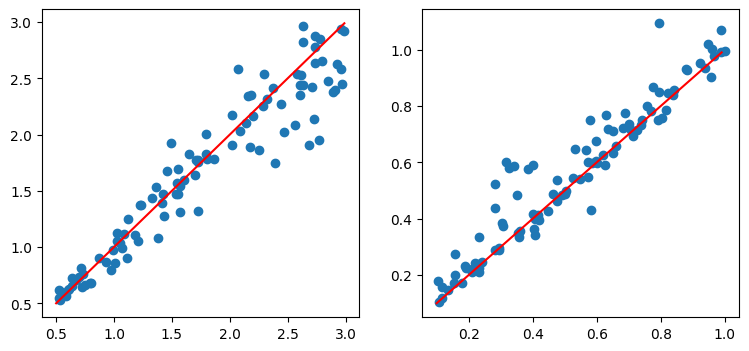

In [23]:
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
# ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))
ndt = np.asanyarray(np.asanyarray(min_rt)/(1 + tf.math.log(1 + tf.math.exp(model.layers[-1].weights[-1]))))


print(r2_score(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold), 
      r2_score(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt))

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold)
plt.plot(np.arange(0.5, 3, 0.01), np.arange(0.5, 3, 0.01), c='red');

plt.subplot(122)
plt.scatter(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt)
plt.plot(np.arange(0.1, 1, 0.01), np.arange(0.1, 1, 0.01), c='red');

437/437 [==============================] - 0s 261us/step
0.8759032531425004 0.8558888261725445
0.9376386035307237 0.9280383483265602


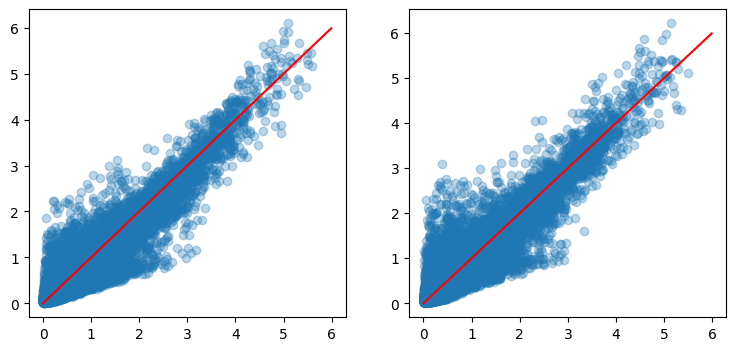

In [24]:
pred_v = model.predict(X_train)
scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in tr_df['sbj']])

print(r2_score(tr_df['true_drift_0'], scaling*pred_v[:, 0]), 
      r2_score(tr_df['true_drift_1'], scaling*pred_v[:, 1]))

print(pearsonr(tr_df['true_drift_0'], scaling*pred_v[:, 0])[0], 
      pearsonr(tr_df['true_drift_1'], scaling*pred_v[:, 1])[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(tr_df['true_drift_0'], scaling*pred_v[:, 0], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

plt.subplot(122)
plt.scatter(tr_df['true_drift_1'], scaling*pred_v[:, 1], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

188/188 [==============================] - 0s 270us/step
0.8816807557742142 0.8537583309127345
0.9404500859276891 0.9277017334348309


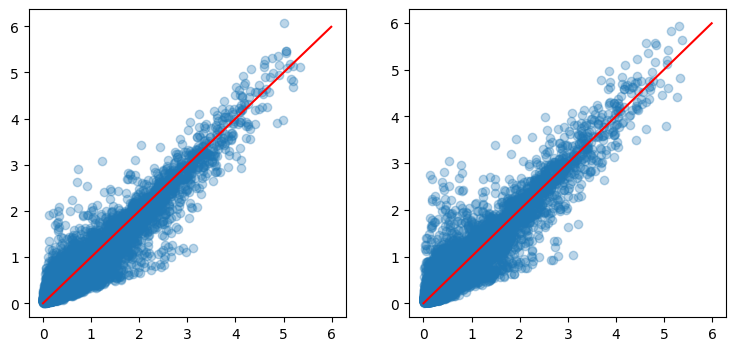

In [25]:
pred_v = model.predict(X_test)
scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

print(r2_score(ts_df['true_drift_0'], scaling*pred_v[:, 0]), 
      r2_score(ts_df['true_drift_1'], scaling*pred_v[:, 1]))

print(pearsonr(ts_df['true_drift_0'], scaling*pred_v[:, 0])[0], 
      pearsonr(ts_df['true_drift_1'], scaling*pred_v[:, 1])[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(ts_df['true_drift_0'], scaling*pred_v[:, 0], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

plt.subplot(122)
plt.scatter(ts_df['true_drift_1'], scaling*pred_v[:, 1], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');